A simple project that uses LSTM to predict Tesla stock price. A regression model is also included at the end to compare the performance.

## Importing libraries

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from finta import TA
from sklearn.metrics import mean_squared_error

## Get data

In [274]:
df = pd.read_csv("data/TSLA.csv", parse_dates=['Date'])
# uncomment for multiple features
df = df.drop(["Adj Close"],axis=1)
# Uncomment for single feature
#df = df.filter(["Date", "Close"])
df.shape

(2874, 6)

In [249]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,34334500


In [250]:
df.tail()

,Date,Open,High,Low,Close,Volume
2869,2021-11-18,1106.550049,1112.000000,1075.020020,1096.380005,20898900
2870,2021-11-19,1098.869995,1138.719971,1092.699951,1137.060059,21168000
2871,2021-11-22,1162.329956,1201.949951,1132.430054,1156.869995,33072500
2872,2021-11-23,1167.510010,1180.500000,1062.699951,1109.030029,36171700
2873,2021-11-24,1080.390015,1132.770020,1062.000000,1116.000000,22560200


In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2874 entries, 0 to 2873
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2874 non-null   datetime64[ns]
 1   Open    2874 non-null   float64       
 2   High    2874 non-null   float64       
 3   Low     2874 non-null   float64       
 4   Close   2874 non-null   float64       
 5   Volume  2874 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 134.8 KB


## Check missing values

In [252]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## Graph the data

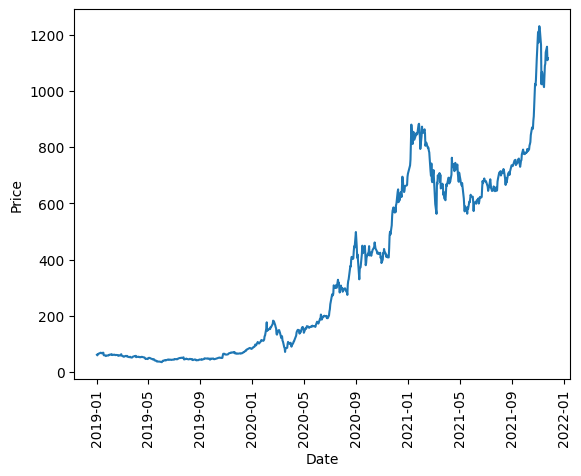

In [253]:
# only showing the data from 2019
mask = (df['Date'] > '2019-1-1')
testDf = df.loc[mask]
plt.plot(testDf["Date"],testDf["Close"])
plt.xticks(rotation='vertical')
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

## Define training and testing datasets for LSTM

In [254]:
trainMask = (df['Date'] < '2021-1-1')
trainDataA = df[trainMask]
trainDataA.tail()

,Date,Open,High,Low,Close,Volume
2642,2020-12-24,642.98999,666.090027,641.000000,661.770020,22865600
2643,2020-12-28,674.51001,681.400024,660.799988,663.690002,32278600
2644,2020-12-29,661.00000,669.900024,655.000000,665.989990,22910800
2645,2020-12-30,672.00000,696.599976,668.359985,694.780029,42846000
2646,2020-12-31,699.98999,718.719971,691.119995,705.669983,49649900


In [255]:
testDataA = df[df["Date"] >= "2021-1-1"]
testDataA.head()

,Date,Open,High,Low,Close,Volume
2647,2021-01-04,719.460022,744.489990,717.190002,729.770020,48638200
2648,2021-01-05,723.659973,740.840027,719.200012,735.109985,32245200
2649,2021-01-06,758.489990,774.000000,749.099976,755.979980,44700000
2650,2021-01-07,777.630005,816.989990,775.200012,816.039978,51498900
2651,2021-01-08,856.000000,884.489990,838.390015,880.020020,75055500


In [256]:
trainData = trainDataA.drop(["Date"], axis =1)
testData = testDataA.drop(["Date"], axis = 1)

## Scale the data

In [257]:
# scale the features
# https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
trainData = scaler.fit_transform(trainData)

## Define x_train and y_train

In [258]:
X_train = []
y_train = []

In [259]:
# generate x & y_train with timestep 60
for i in range(60, trainData.shape[0]):
    # i not included here
    X_train.append(trainData[i-60: i])
    # change to i,0 if only 1 feature otherwise i, 3
    y_train.append(trainData[i,3])

In [260]:
# Convert into np
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2587, 60, 5), (2587,))

## LSTM Model

In [261]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [262]:
model = Sequential()
# input + hidden
# change to X_train.shape[1], 1 if single feature other wise ,5
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 5)))
#model.add(Dropout(0.2))
model.add(LSTM(64, activation="relu"))
# Testing different layers + dropout 
#model.add(Dropout(0.2))
#model.add(LSTM(256, return_sequences=False, activation = "relu"))
#model.add(Dropout(0.2))
#model.add(LSTM(128, activation = "relu"))
#model.add(Dropout(0.2))
# output
model.add(Dense(1))

In [263]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 60, 128)           68608     
                                                                 
 lstm_21 (LSTM)              (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [264]:
# compile 
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
81/81 [==============================] - 6s 45ms/step - loss: 0.0019
Epoch 2/10
81/81 [==============================] - 3s 41ms/step - loss: 2.9119e-04
Epoch 3/10
81/81 [==============================] - 3s 39ms/step - loss: 2.7853e-04
Epoch 4/10
81/81 [==============================] - 3s 41ms/step - loss: 2.6040e-04
Epoch 5/10
81/81 [==============================] - 3s 41ms/step - loss: 2.4497e-04
Epoch 6/10
81/81 [==============================] - 4s 43ms/step - loss: 2.5067e-04
Epoch 7/10
81/81 [==============================] - 3s 41ms/step - loss: 2.0655e-04
Epoch 8/10
81/81 [==============================] - 3s 42ms/step - loss: 2.0931e-04
Epoch 9/10
81/81 [==============================] - 3s 43ms/step - loss: 1.5706e-04
Epoch 10/10
81/81 [==============================] - 3s 42ms/step - loss: 1.6208e-04


## Define test data

In [265]:
testDataA.head()

,Date,Open,High,Low,Close,Volume
2647,2021-01-04,719.460022,744.489990,717.190002,729.770020,48638200
2648,2021-01-05,723.659973,740.840027,719.200012,735.109985,32245200
2649,2021-01-06,758.489990,774.000000,749.099976,755.979980,44700000
2650,2021-01-07,777.630005,816.989990,775.200012,816.039978,51498900
2651,2021-01-08,856.000000,884.489990,838.390015,880.020020,75055500


In [266]:
# add the previous 60 days, we need it to predict 
prev_60 = trainDataA.tail(60)
df = prev_60.append(testDataA, ignore_index = True)
df = df.drop(["Date"], axis=1)
df.head()

,Open,High,Low,Close,Volume
0,419.869995,429.899994,413.850006,425.299988,43127700
1,438.440002,439.000000,425.299988,425.920013,40421100
2,430.130005,434.589996,426.459991,434.000000,28925700
3,442.000000,448.739990,438.579987,442.299988,38791100
4,443.350006,448.890015,436.600006,446.649994,34463700


In [267]:
df = scaler.transform(df)

In [268]:
X_test = []
y_test = []

for i in range(60, df.shape[0]):
    X_test.append(df[i-60:i])
    # change to i, 0 if single feature otherwise ,3
    y_test.append(df[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((227, 60, 5), (227,))

## Predict

In [269]:
y_pred = model.predict(X_test)
y_pred.shape

(227, 1)

In [270]:
# invert scale, get the scale factor for our close column
scaler.scale_

array([1.43521032e-03, 1.39783118e-03, 1.45322646e-03, 1.42346732e-03,
       3.28837576e-09])

In [272]:
# invert the scale
scale = 1/1.42346732e-03
y_pred = y_pred*scale
y_test = y_test*scale
mean_squared_error(y_test, y_pred, squared=False)

44.06415574235226

## Graph the results

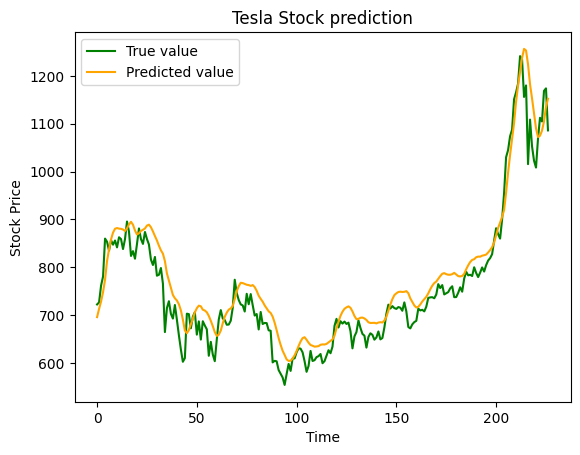

In [273]:
plt.plot(y_test, color = "green", label="True value")
plt.plot(y_pred, color = "orange", label="Predicted value")
plt.title("Tesla Stock prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

## Let's try with a simple regression model from Sklearn
Run Get Data (the second block) code before this

In [275]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
X = df.drop(["Close", "Date"],axis=1)
y = df.filter(["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07898399443, shuffle=False)


# train and evaluate
reg = LinearRegression().fit(X_train, y_train)
#print(reg.coef_)
print("We get the following RMSE")
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

We get the following RMSE


9.862444218304313

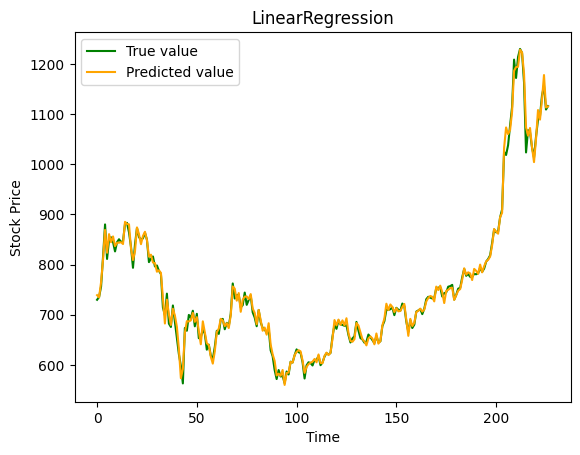

In [276]:
xAxis = [i for i in range(227)]
plt.plot(xAxis, y_test, color = "green", label="True value")
plt.plot(xAxis, y_pred, color = "orange", label="Predicted value")
plt.title("LinearRegression")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()